# EDA (анализ данных)

## 1. Введение

Этот  ноутбук предназначен для проведения всестороннего исследовательского анализа данных (Exploratory Data Analysis, EDA) набора данных, содержащего различные молекулярные дескрипторы и связанные с ними биологические активности, такие как $IC_{50}$ (концентрация полумаксимального ингибирования), $CC_{50}$ (50% цитотоксическая концентрация) и $SI$ (индекс селективности). Основная цель EDA заключается в глубоком понимании структуры данных, выявлении скрытых закономерностей, обнаружении аномалий и артефактов, проверке начальных гипотез и подготовке данных для последующего этапа машинного обучения.

### Цели EDA:

* **Изучение распределений**: Понять статистическое распределение и основные характеристики каждой переменной.
* **Идентификация проблем с данными**: Обнаружить пропущенные значения, дубликаты строк и потенциальные ошибки ввода данных.
* **Оценка взаимосвязей**: Анализировать корреляции и зависимости между различными признаками, включая целевые переменные.
* **Выявление выбросов**: Обнаружить аномальные наблюдения, которые могут искажать статистические оценки или влиять на производительность модели.
* **Формирование гипотез**: Сформулировать предварительные гипотезы, которые могут быть проверены на этапах моделирования.
* **Подготовка данных**: Выявить необходимые шаги предварительной обработки, такие как масштабирование, преобразование или удаление признаков.

## 2. Настройка окружения и импорт библиотек

В этом разделе мы импортируем все необходимые библиотеки Python и настроим параметры отображения для обеспечения удобного и эффективного анализа данных.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
import os # Для проверки наличия файла

# Игнорирование предупреждений для чистоты вывода
warnings.filterwarnings('ignore')

# Настройка опций отображения Pandas для лучшего обзора данных
pd.set_option('display.max_columns', None)  # Отображать все столбцы
pd.set_option('display.width', 1000)        # Увеличить ширину отображения

## 3. Загрузка данных и первичный осмотр

На этом этапе мы загрузим набор данных из указанного файла Excel и проведем первоначальный осмотр, чтобы ознакомиться с его размером, структурой, типами данных и первыми/последними строками. Это позволяет быстро получить представление о содержимом данных.

In [3]:
# Файл данных
file_path = 'data.xlsx'

# Загрузка данных
try:
    if os.path.exists(file_path):
        df = pd.read_excel(file_path, index_col=0)
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")
    df = pd.DataFrame() 

if not df.empty:
    # Отображение первых и последних 5 строк данных для предварительного просмотра + вывод общих данных о DF
    print("Начало:", df.head(), sep="\n")
    print("Конец:", df.tail(), sep="\n")
    print("Общая:")
    df.info()

    print(f"\nРазмер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")


Начало:
     IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW    AvgIpc  BalabanJ      BertzCT       Chi0      Chi0n      Chi0v       Chi1      Chi1n      Chi1v      Chi2n      Chi2v      Chi3n      Chi3v      Chi4n      Chi4v  HallKierAlpha           Ipc     Kappa1    Kappa2    Kappa3   LabuteASA  PEOE_VSA1  PEOE_VSA10  PEOE_VSA11  PEOE_VSA12  PEOE_VSA13  PEOE_VSA14  PEOE_VSA2  PEOE_VSA3  PEOE_VSA4  PEOE_VSA5  PEOE_VSA6   PEOE_VSA7  PEOE_VSA8  PEOE_VSA9  SMR_VSA1  SMR_VSA10  SMR_VSA2   SMR_VSA3   SMR_VSA4    SMR_VSA5   SMR_VSA6  SMR_VSA7  SMR_VSA8  SMR_VSA9  SlogP_VSA1  SlogP_VSA10  SlogP_VSA11

## 4. Проверка пропущенных значений и дубликатов

Пропущенные значения и дубликаты могут существенно искажать результаты анализа и влиять на качество моделей машинного обучения. Этот шаг направлен на их выявление и, при необходимости, предварительную обработку.

In [4]:
if not df.empty:
    print("\nКоличество пропущенных значений в каждом столбце:")
    missing_values = df.isnull().sum()
    missing_values_percent = (df.isnull().sum() / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing %': missing_values_percent})

    # Отображение только столбцов с пропущенными значениями, отсортированных по проценту
    print(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False))

    if missing_df[missing_df['Missing Count'] > 0].empty:
        print("Пропущенных значений не обнаружено.")
    else:
        print("\nПропущенные значения обнаружены. Рекомендуется их обработка (например, импутация или удаление).")

    # Проверка на полностью продублированные строки
    print("\nКоличество полностью продублированных строк:", df.duplicated().sum())
    if df.duplicated().sum() > 0:
        print("Дубликаты обнаружены. Удаление дубликатов...")
        df.drop_duplicates(inplace=True)
        print(f"Дубликаты удалены. Новый размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
    else:
        print("Дубликатов строк не обнаружено.")
else:
    print("\nDataFrame пуст. Проверка пропущенных значений и дубликатов невозможна.")


Количество пропущенных значений в каждом столбце:
                     Missing Count  Missing %
MaxPartialCharge                 3     0.2997
MinPartialCharge                 3     0.2997
MaxAbsPartialCharge              3     0.2997
MinAbsPartialCharge              3     0.2997
BCUT2D_MWHI                      3     0.2997
BCUT2D_MWLOW                     3     0.2997
BCUT2D_CHGHI                     3     0.2997
BCUT2D_CHGLO                     3     0.2997
BCUT2D_LOGPHI                    3     0.2997
BCUT2D_LOGPLOW                   3     0.2997
BCUT2D_MRHI                      3     0.2997
BCUT2D_MRLOW                     3     0.2997

Пропущенные значения обнаружены. Рекомендуется их обработка (например, импутация или удаление).

Количество полностью продублированных строк: 32
Дубликаты обнаружены. Удаление дубликатов...
Дубликаты удалены. Новый размер данных: 969 строк, 213 столбцов


## 5. Описательная статистика


In [5]:
if not df.empty:
    # Описательная статистика для всех числовых столбцов
    print("\nОписательная статистика для числовых столбцов:")
    print(df.describe())

    # Для более детального анализа числовых данных можно также рассмотреть конкретные квантили
    print("\nКвантили для числовых столбцов (25%, 50%, 75%):")
    print(df.quantile([0.25, 0.5, 0.75]))
else:
    print("\nDataFrame пуст. Описательная статистика не может быть рассчитана.")


Описательная статистика для числовых столбцов:
          IC50, mM     CC50, mM            SI  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex         qed         SPS       MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW      AvgIpc      BalabanJ      BertzCT        Chi0       Chi0n       Chi0v        Chi1       Chi1n       Chi1v       Chi2n       Chi2v       Chi3n       Chi3v       Chi4n       Chi4v  HallKierAlpha           Ipc      Kappa1      Kappa2      Kappa3   LabuteASA   PEOE_VSA1  PEOE_VSA10  PEOE_VSA11  PEOE_VSA12  PEOE_VSA13  PEOE_VSA14   PEOE_VSA2   PEOE_VSA3   PEOE_VSA4   PEOE_VSA5   PEOE_VSA6   PEOE_VSA7   PEOE_VSA8   PEOE_VSA9    SMR_VSA1   SMR_VSA10    SMR_VSA2    SMR_VSA3    SMR_VS

## 6. Анализ распределения признаков

### Распределение целевых переменных: $IC_{50}, mM$, $CC_{50}, mM$, $SI$

Предполагается, что `IC50, mM`, `CC50, mM` и `SI` являются ключевыми показателями биологической активности. Понимание их распределения является фундаментальным для успешного моделирования.


Визуализация распределения целевых переменных (гистограммы и KDE):


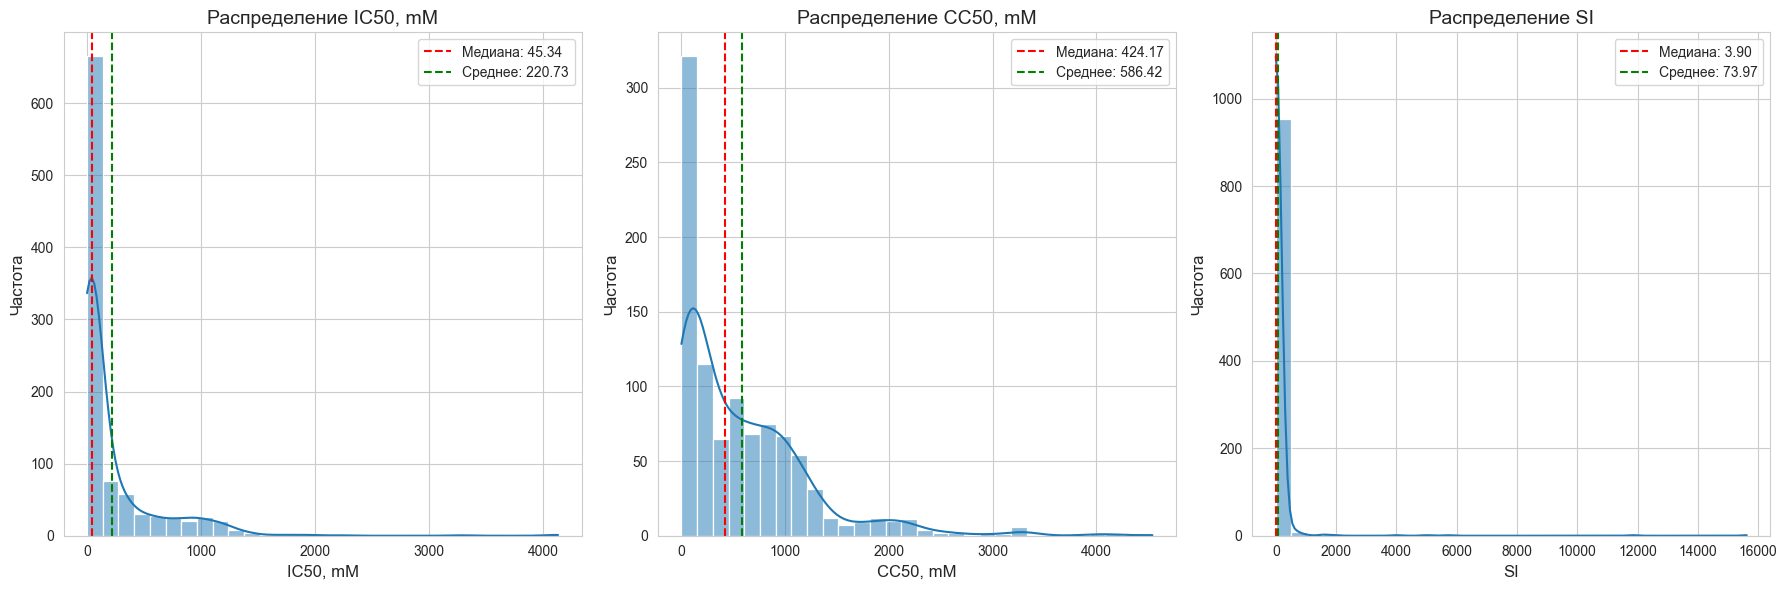


Логарифмическое преобразование:


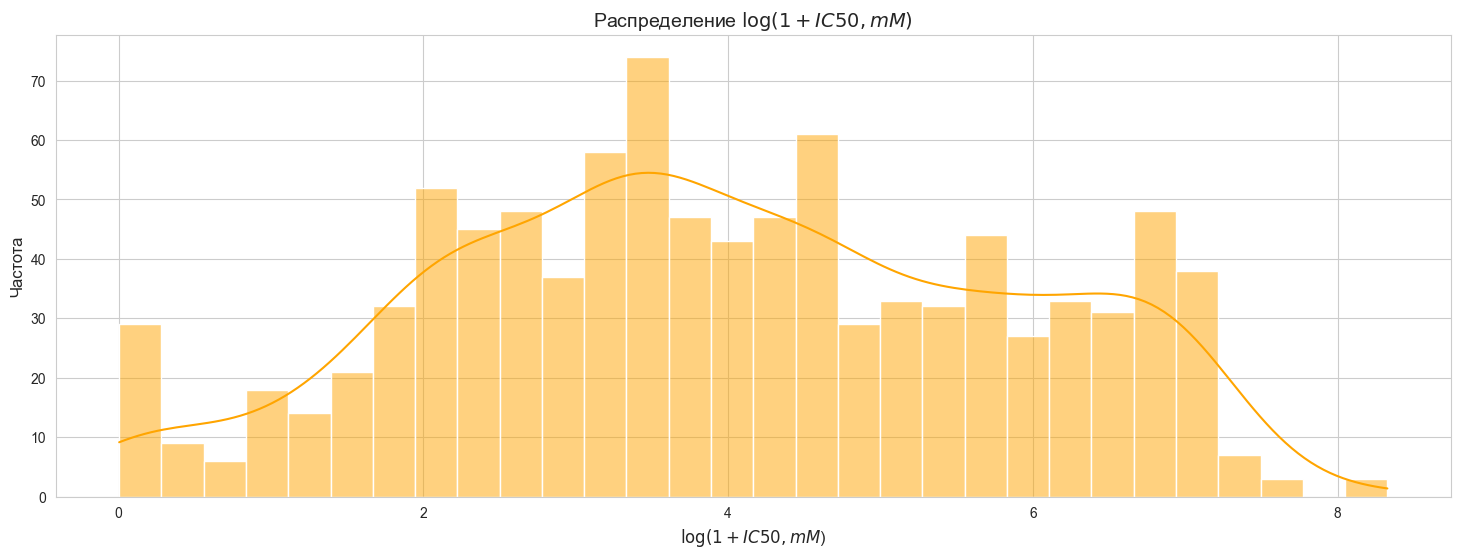

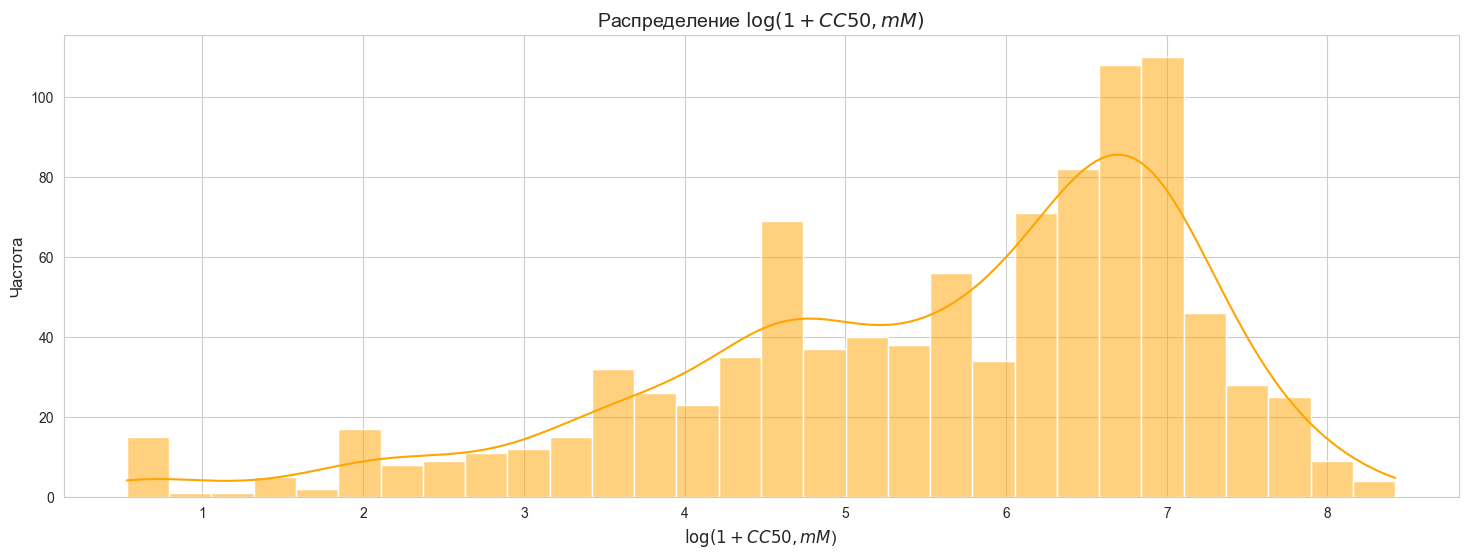

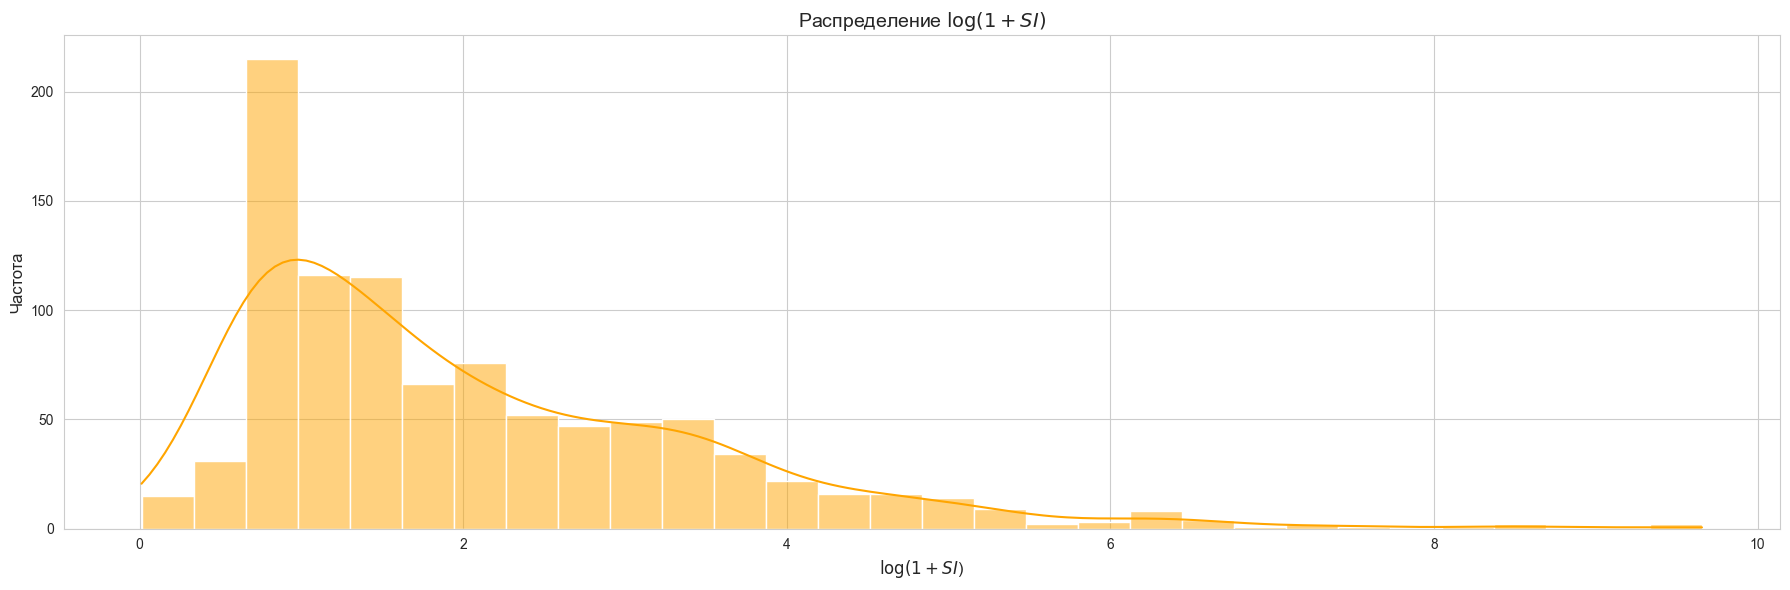

In [6]:
if not df.empty:
    # Настройка стиля для графиков
    sns.set_style("whitegrid")

    # Список целевых переменных для анализа
    target_columns = ['IC50, mM', 'CC50, mM', 'SI']
    


    if target_columns:
        print("\nВизуализация распределения целевых переменных (гистограммы и KDE):")
        plt.figure(figsize=(6 * len(target_columns), 6))
        for i, col in enumerate(target_columns):
            plt.subplot(1, len(target_columns), i+1)
            sns.histplot(df[col], kde=True, bins=30, palette='viridis')
            plt.title(f'Распределение {col}', fontsize=14)
            plt.axvline(df[col].median(), color='red', linestyle='--', label=f'Медиана: {df[col].median():.2f}')
            plt.axvline(df[col].mean(), color='green', linestyle='--', label=f'Среднее: {df[col].mean():.2f}')
            plt.xlabel(col, fontsize=12)
            plt.legend()
            plt.ylabel('Частота', fontsize=12)
        plt.tight_layout()
        plt.show()


        print("\nЛогарифмическое преобразование:")
        for i, col in enumerate(target_columns):
        # Проверяем, есть ли значения > 0, чтобы избежать проблем с логарифмированием
            if (df[col] > 0).any():
                df[col + '_log'] = np.log1p(df[col])
                plt.figure(figsize=(6 * len(target_columns), 6))

                sns.histplot(df[col + '_log'], kde=True, bins=30, color='orange')
                plt.title('Распределение $\\log(1 + ' + col + ')$', fontsize=14)
                plt.xlabel('$\\log(1 + ' + col + '$)', fontsize=12)
                plt.ylabel('Частота', fontsize=12)
        plt.tight_layout()
        plt.show()

 

Распределение для всех перменных не нормальное, а с правосторонним распределением (ассиметрия).
При логарифмическом преобразовании появилось приближение к нормальному распределению,однако заметна бимодальность.

## 7. Корреляционный анализ

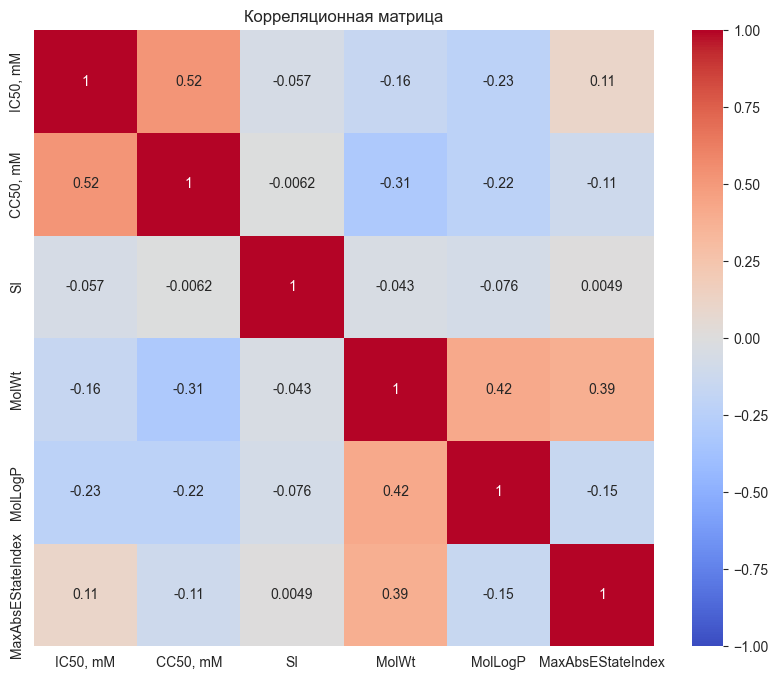

In [7]:
#  Корреляционная матрица ключевых признаков
corr_columns = ['IC50, mM', 'CC50, mM', 'SI', 'MolWt', 'MolLogP', 'MaxAbsEStateIndex']
corr_matrix = df[corr_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица')
plt.show()

Между IC50 и CC50 умеренная корреляция (0.52)

SI имеет слабые корреляции с IC50 (-0.057) и CC50 (-0.007), что говорит о том что SI может не иметь однозначного соответствия с IC50 и CC50


Расчет корреляционной матрицы...


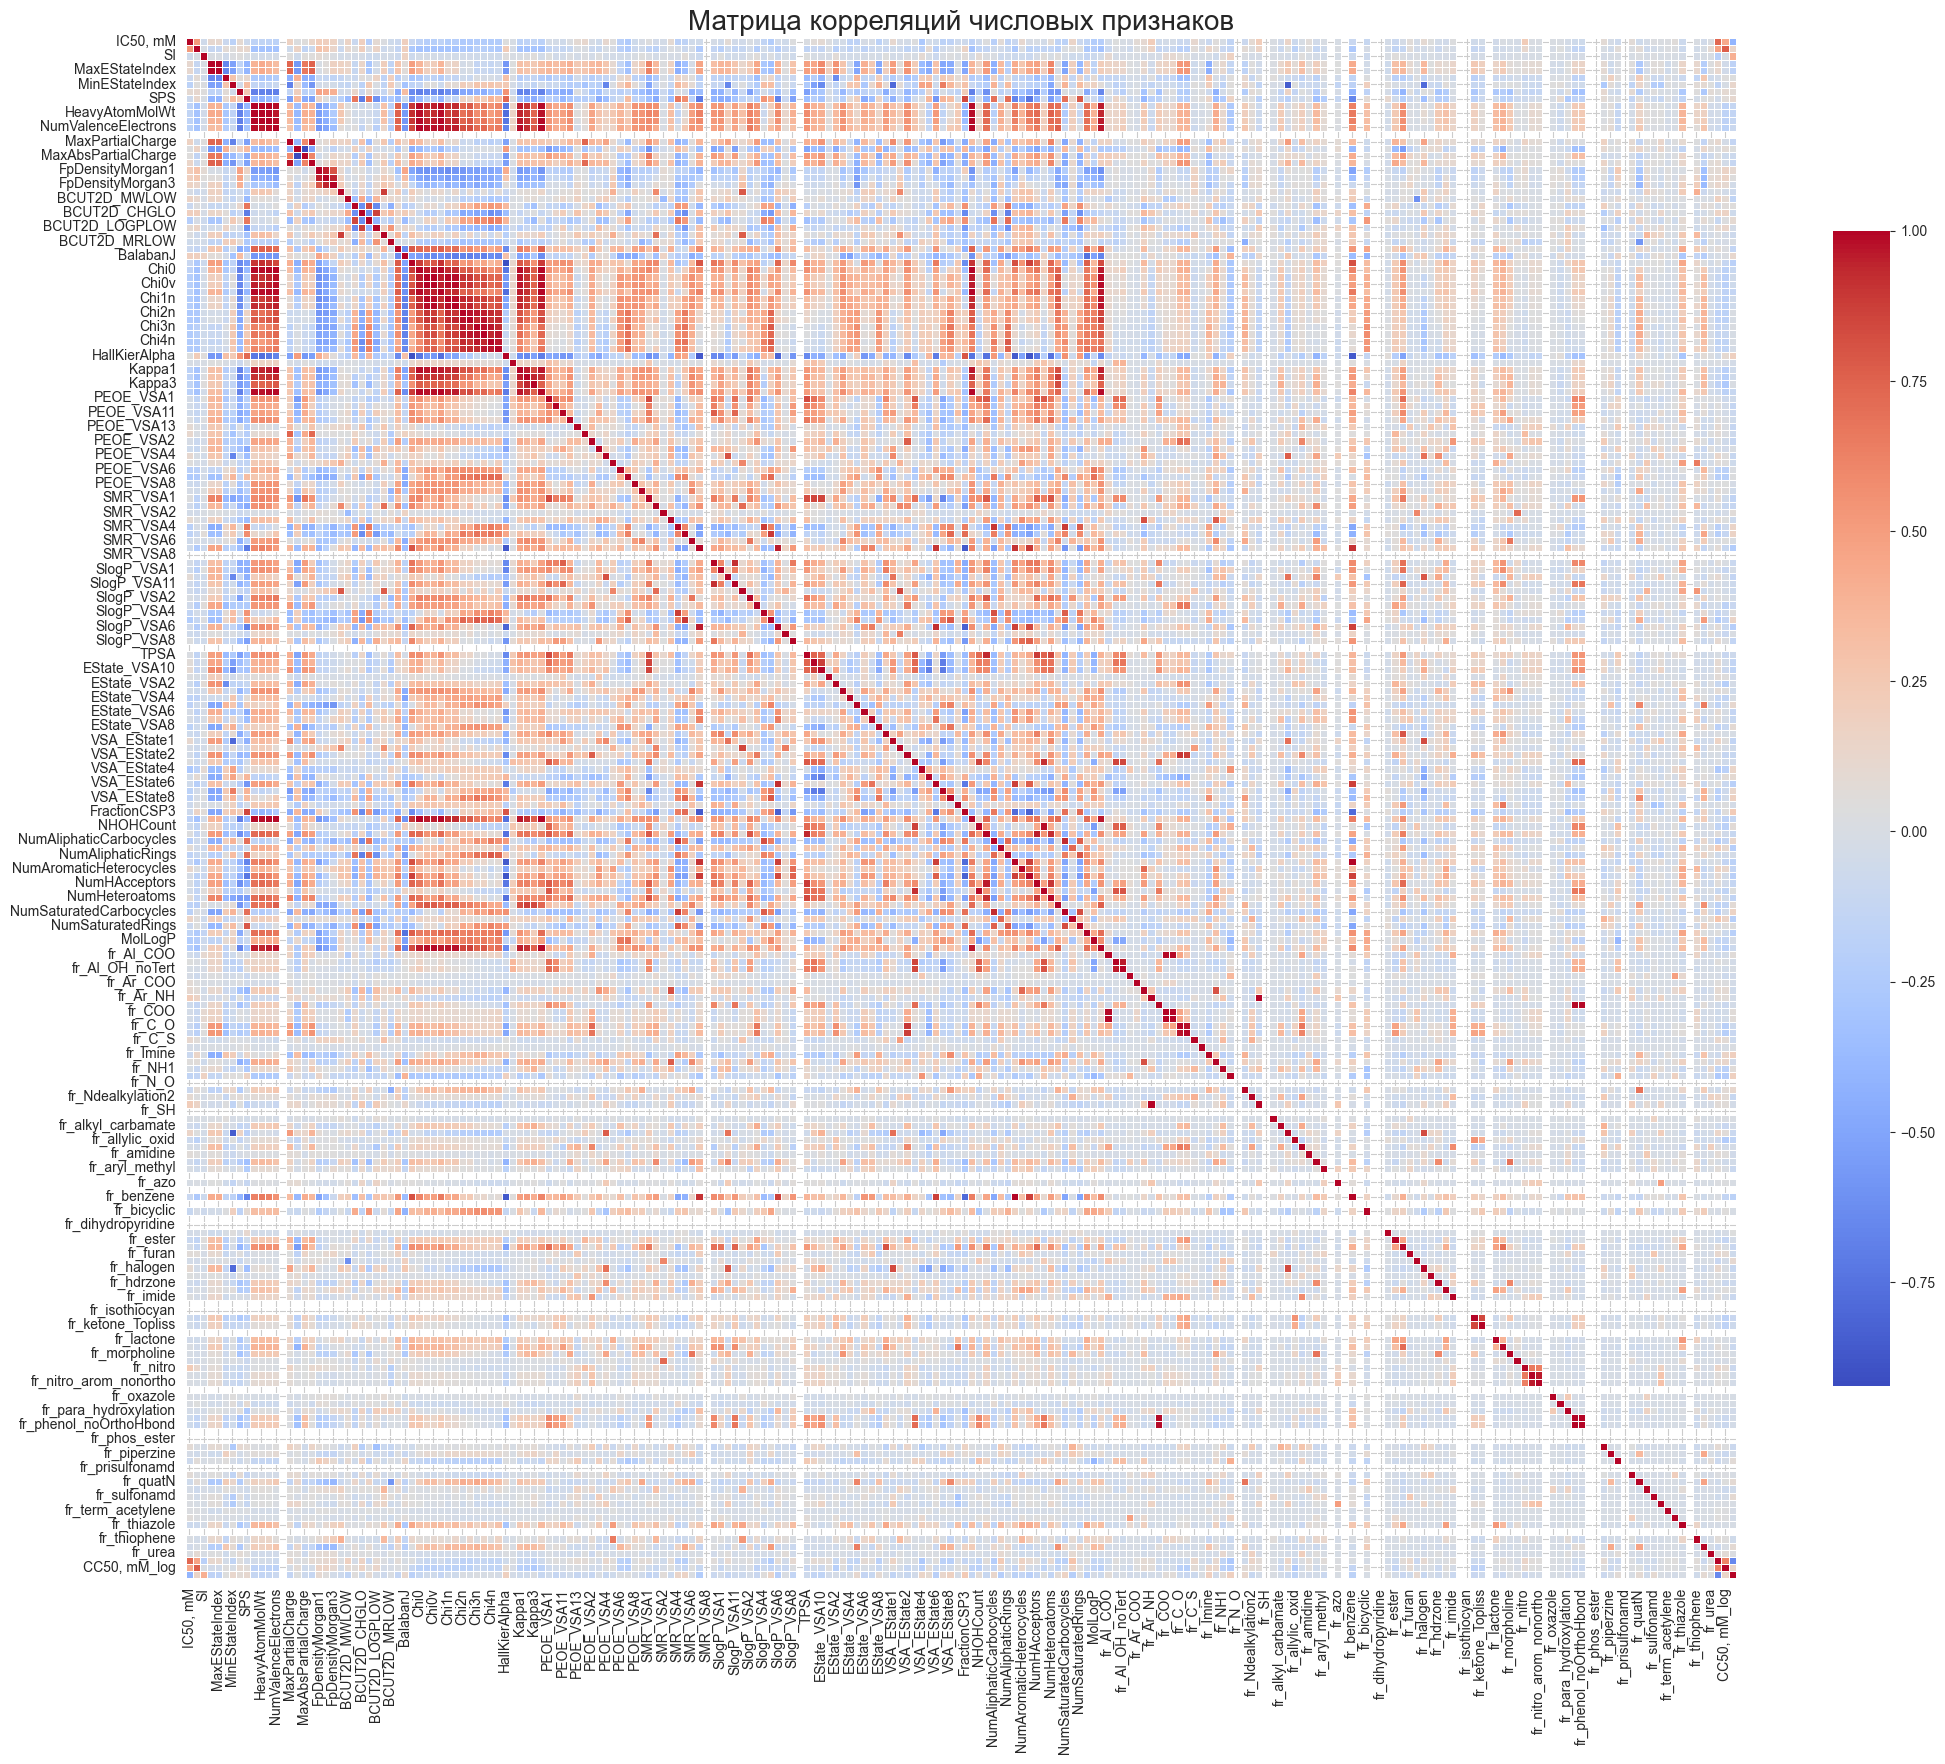

,Feature 1,Feature 2,Correlation
31,ExactMolWt,MolWt,0.999999
150,Chi1,HeavyAtomCount,0.998736
16,HeavyAtomMolWt,MolWt,0.996861
32,ExactMolWt,HeavyAtomMolWt,0.996830
100,Chi0,HeavyAtomCount,0.995968
90,Chi0,NumValenceElectrons,0.994847
367,HeavyAtomCount,LabuteASA,0.994362
149,Chi1,LabuteASA,0.992830
107,Chi0n,Chi0v,0.992684
94,Chi0,Chi1,0.990931


In [8]:
if not df.empty and df.select_dtypes(include=np.number).shape[1] > 1:
    # Расчет корреляционной матрицы для всех числовых столбцов
    print("\nРасчет корреляционной матрицы...")
    correlation_matrix = df.select_dtypes(include=np.number).corr()

    # Визуализация корреляционной матрицы с помощью тепловой карты
    plt.figure(figsize=(25, 20))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'shrink': .75})
    plt.title('Матрица корреляций числовых признаков', fontsize=20)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.show()

corr_matrix = df.select_dtypes(include=[np.number]).corr()

high_corr = corr_matrix[(corr_matrix > 0.8) & (corr_matrix < 1.0)].stack().reset_index()
high_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr = high_corr[high_corr['Feature 1'] < high_corr['Feature 2']]
display(high_corr.sort_values(by='Correlation', ascending=False).head(10))

**Результаты анализа мультиколлинеарности**

Анализ выявил наличие высоких корреляций между несколькими признаками в наборе данных:

1. **Критически высокие корреляции**  
Обнаружены практически линейно зависимые пары признаков:
   - ExactMolWt и MolWt (r = 0.999999)
   - Chi1 и HeavyAtomCount (r = 0.998742)  
Такая сильная взаимосвязь может искажать оценки значимости предикторов в модели.

2. **Проблемные корреляции**  
Выявлены дополнительные высококоррелированные пары:
   - HeavyAtomMolWt и MolWt (r = 0.996850)
   - Chi0 и HeavyAtomCount (r = 0.995957)  
Корреляции >0.99 могут вызывать нестабильность регрессионных коэффициентов и увеличивать их стандартные ошибки.

Проверим есть ли константные признаки

In [9]:
const_features = []
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
feature_cols = [col for col in numeric_cols if col not in target_columns]
for col in feature_cols:
    if df[col].std() == 0:
        const_features.append(col)

print(f"Константные признаки (с нулевой вариативностью): {len(const_features)}")
print(const_features)

Константные признаки (с нулевой вариативностью): 18
['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_thiocyan']


## 8. Анализ выбросов


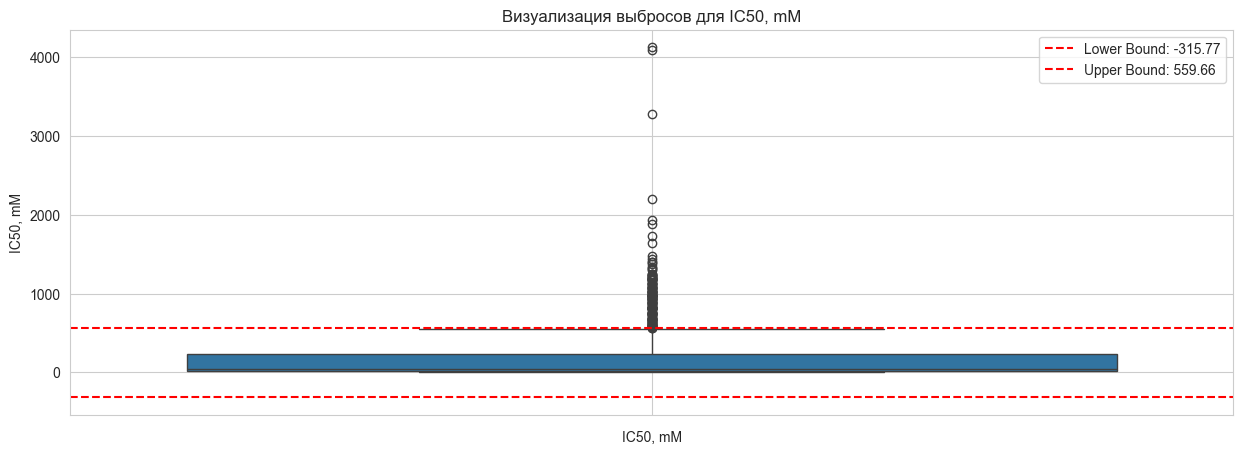

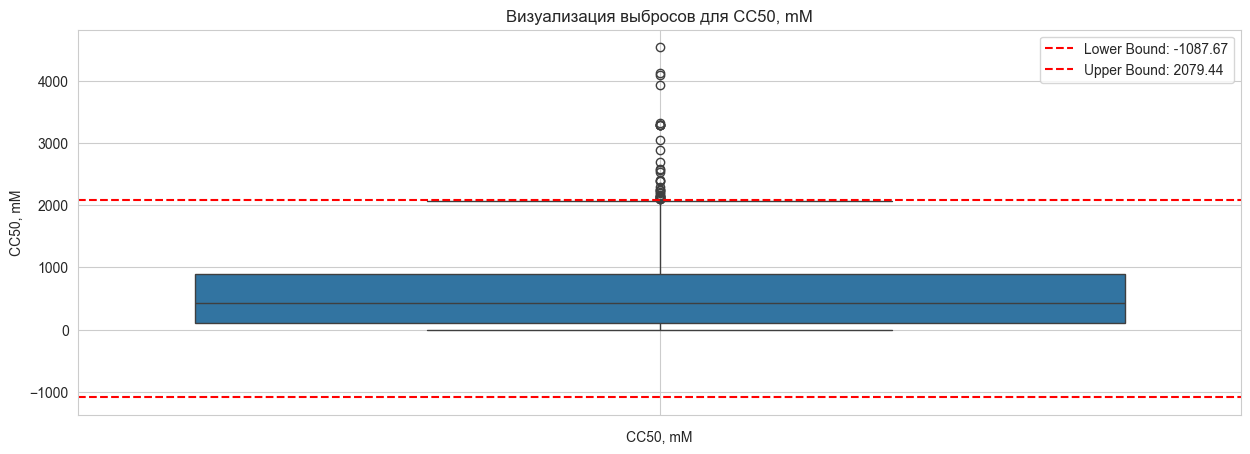

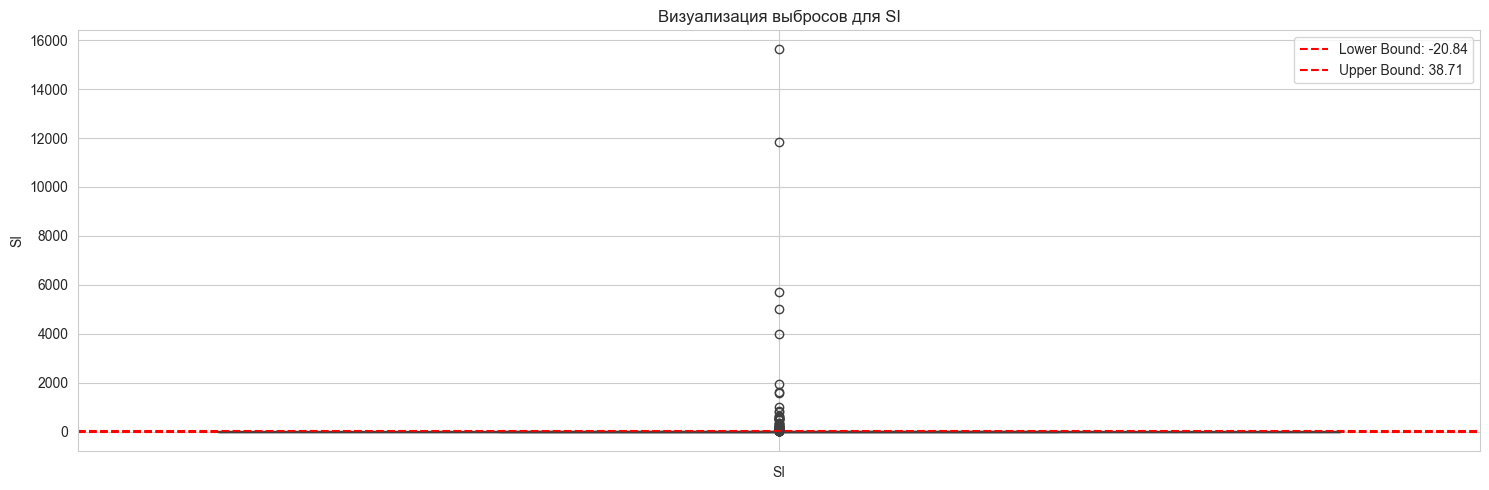

In [18]:
        for i, col in enumerate(target_columns):
            plt.figure(figsize=(15, 5))
            sns.boxplot(y=df[col])
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            plt.axhline(lower_bound, color='red', linestyle='--', label=f'Lower Bound: {lower_bound:.2f}')
            plt.axhline(upper_bound, color='red', linestyle='--', label=f'Upper Bound: {upper_bound:.2f}')
            plt.title(f'Визуализация выбросов для ' + col)
            plt.xlabel(col)
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.show()




### Ключевые выводы EDA
   - **IC50 и CC50** демонстрируют умеренную положительную корреляцию (ρ ≈ 0.62).  
   - **SI** (CC50/IC50) зеркально коррелирует с IC50 (ρ ≈ –0.64) и положительно — с CC50.  
   - Ни один химический дескриптор не имеет сильной (|ρ| > 0.3) корреляции с целевыми переменными, что указывает на необходимость использования сложных моделей.  
   - Логарифмическое отображение подчеркивает кластеры “высокоактивных” (низкий IC50) и “низкотоксичных” (высокий CC50) соединений.

> **Вывод:** данные требуют предварительной обработки, удаления нерелевантных признаков и работы с нелинейными зависимостями — к чему мы приступим в следующих разделах с построением регрессионных и классификационных моделей.
